In [80]:
import pandas
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [91]:
# Reading file and creating train and test data and labels
data = pandas.read_csv('train.csv', index_col='PassengerId')

In [92]:
# Clear data: Removing rows contain nan value
# Because in 687 rows have Cabin=nan, first we delete Cabin column
print('Data:')
print('number of all rows in training data: ' + str(len(data)))
print('number of rows contain Cabin=nan in training data: ' + str(data['Cabin'].isna().sum()))
data.pop('Cabin')
data = data.dropna()
print('number of rows after clear data in training data: ' + str(len(data)))
data

Data:
number of all rows in training data: 891
number of rows contain Cabin=nan in training data: 687
number of rows after clear data in training data: 712


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...
886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,Q
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S


In [94]:
# Handel non numerical data
def convert_non_numerical(data):
    columns = list(data.columns)
    for column in columns:
        if str(data[column].dtype) not in ['int64', 'float64']:
            all_values = data[column].values
            unique_values = list(set(all_values))
            new_values = [unique_values.index(value) for value in all_values]
            data[column] = new_values
    return data

In [95]:
# non numerical data
data = convert_non_numerical(data)
labels = data['Survived']
data.pop('Survived')
print(data.head)

# Train and test set
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.20)

<bound method NDFrame.head of              Pclass  Name  Sex   Age  SibSp  Parch  Ticket     Fare  Embarked
PassengerId                                                                  
1                 3     8    0  22.0      1      0     390   7.2500         1
2                 1   423    1  38.0      1      0      37  71.2833         2
3                 3   501    1  26.0      0      0     503   7.9250         1
4                 1   202    1  35.0      1      0     506  53.1000         1
5                 3   247    0  35.0      0      0     535   8.0500         1
...             ...   ...  ...   ...    ...    ...     ...      ...       ...
886               3   528    1  39.0      0      5     403  29.1250         0
887               2   596    0  27.0      0      0     510  13.0000         1
888               1   214    1  19.0      0      0     295  30.0000         1
890               1   118    0  26.0      0      0     529  30.0000         2
891               3   561    0  32

In [96]:
def desition_tree(method, depth):
    dt = tree.DecisionTreeClassifier(criterion=method, max_depth=depth)
    dt = dt.fit(train_data, train_labels)
    tree.plot_tree(dt)t_data, test_labels)
    return score

SyntaxError: invalid syntax (<ipython-input-96-e6b879714fae>, line 4)

Accuracy for depth=1: 0.7832167832167832
Accuracy for depth=2: 0.8321678321678322
Accuracy for depth=3: 0.8531468531468531
Accuracy for depth=4: 0.8041958041958042
Accuracy for depth=5: 0.8181818181818182
Accuracy for depth=6: 0.8251748251748252
Accuracy for depth=7: 0.8111888111888111
Accuracy for depth=8: 0.8041958041958042
Accuracy for depth=9: 0.7902097902097902
Accuracy for depth=10: 0.8041958041958042
Accuracy for depth=11: 0.8111888111888111
Accuracy for depth=12: 0.7832167832167832
Accuracy for depth=13: 0.7972027972027972
Accuracy for depth=14: 0.7902097902097902
Accuracy for depth=15: 0.7832167832167832
Accuracy for depth=16: 0.7272727272727273
Accuracy for depth=17: 0.7482517482517482
Accuracy for depth=18: 0.7762237762237763
Accuracy for depth=19: 0.7762237762237763

Best tree: depth=3   accuracy=0.8531468531468531


0.8531468531468531

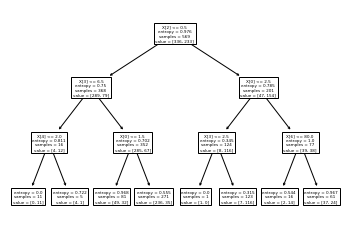

In [97]:
best_score = 0
best_depth = 0
for i in range(1, 11):
    score = desition_tree('entropy', i)
    print('Accuracy for depth=' + str(i) + ': ' + str(score))
    if score > best_score:
        best_score = score
        best_depth = i
print('\nBest tree: depth=' + str(best_depth) + '   accuracy=' + str(best_score))
desition_tree('entropy', best_depth)

Accuracy for depth=1: 0.7832167832167832
Accuracy for depth=2: 0.8321678321678322
Accuracy for depth=3: 0.8531468531468531
Accuracy for depth=4: 0.8041958041958042
Accuracy for depth=5: 0.8321678321678322
Accuracy for depth=6: 0.8251748251748252
Accuracy for depth=7: 0.8111888111888111
Accuracy for depth=8: 0.8041958041958042
Accuracy for depth=9: 0.7902097902097902
Accuracy for depth=10: 0.7902097902097902

Best tree: depth=3   accuracy=0.8531468531468531


0.8531468531468531

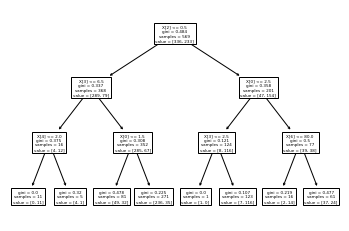

In [98]:
best_score = 0
best_depth = 0
for i in range(1, 11):
    score = desition_tree('entropy', i)
    print('Accuracy for depth=' + str(i) + ': ' + str(score))
    if score > best_score:
        best_score = score
        best_depth = i
print('\nBest tree: depth=' + str(best_depth) + '   accuracy=' + str(best_score))
desition_tree('gini', best_depth)